# Expedia hotel recommendation

Only train on booking events, `is_booking == 1`.
___

In [75]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import sparse
import random
import re
import sys
import multiprocessing
from collections import defaultdict, OrderedDict

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import ml_metrics
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
def formatdata(chunk):
    '''Format data of each startified chunk.'''
    
    # fill NAs for origin-destination distance
    # chunk['orig_destination_distance'].fillna(0.0, inplace=True)
    chunk.dropna(axis=0, subset=['orig_destination_distance'], inplace=True)
      
    return chunk

def stratshufspl(chunk, fraction, ylabel):
    '''Startified shuffle split of chunks.'''
    sss = StratifiedShuffleSplit(chunk[ylabel], test_size=fraction, 
                                 random_state=42, n_iter=1)
    for _, idx in sss:
        train = chunk.iloc[idx].copy()
    return train


def fractionate(trainiter, fraction, ylabel):
    '''Utilizes only one core.'''
    print('')
    print('loading data...')
    
    # create empty list and add formatted data chunks
    chunks = list()
    for chunk in trainiter:
        chunk = chunk[chunk['is_booking']==1]   # train only on booking events
        # if using whole dataset skip this step
        if fraction < 1.0:
            chunk = stratshufspl(chunk, fraction, ylabel)
        curr = formatdata(chunk)
        chunks.append(curr)
        
    # concatenate chunks
    train = pd.concat(chunks, axis=0)
    
    # split concatenated set into X and y for ml model fitting
    X = train.drop([ylabel, 'is_booking'], axis=1, inplace=False)
    y = train[ylabel]
    return X, y

In [77]:
dataurl = '/Users/dbricare/Documents/Python/datasets/expedia/'

rawcols = ['user_location_city', 'orig_destination_distance', 'is_booking', 'hotel_cluster']

ylabel = rawcols[-1]

# csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', compression='gzip', chunksize=2000000, usecols=rawcols)
csviter = pd.read_csv(dataurl+'train.csv.gz', sep=',', chunksize=1000000, usecols=rawcols)

X, y = fractionate(csviter, 0.2, rawcols[-1])

print(X.shape)
print(X.columns)
X.head()


loading data...
(396954, 2)
Index(['user_location_city', 'orig_destination_distance'], dtype='object')


,user_location_city,orig_destination_distance
669455,25315,3939.6881
255860,5070,414.0835
117285,10553,4094.8274
982084,2428,924.9407
435781,10800,6808.6816


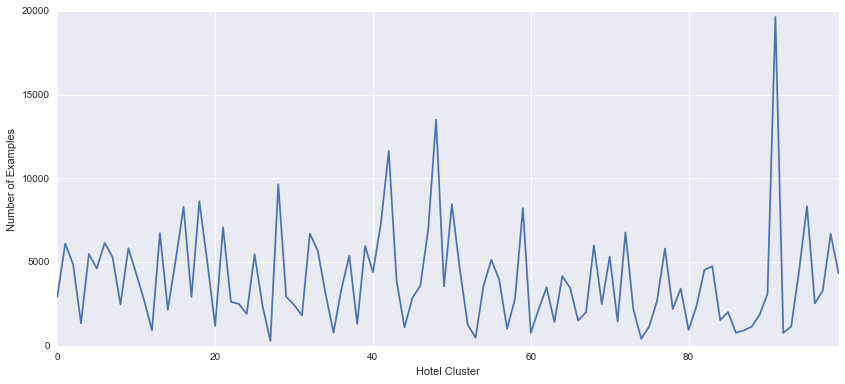

In [78]:
# Distribution of hotel cluster occurrences

f = y.value_counts(sort=False).plot(figsize=(14,6))
_ = f.set_ylabel('Number of Examples')
_ = f.set_xlabel('Hotel Cluster')

## One hot encoding

In [72]:
notcats = ['orig_destination_distance']
cats = list(X.columns)
for cat in notcats:
    cats.remove(cat)
    
print('expected number of columns in sparse matrix:', X[cats].max().sum()+len(X.columns))

expected number of columns in sparse matrix: 56509


In [44]:
# check test data

testiter = pd.read_csv(dataurl+'test.csv.gz', sep=',', compression='gzip', 
                       chunksize=100000, usecols=rawcols[:-1])
first = True
for chunk in testiter:
    chunk = formatdata(chunk)
    currmin = chunk[cats].min()
    currmax = chunk[cats].max()
    if first:
        minvals = currmin
        maxvals = currmax
        first = False
    else:
        if any([both[0]!=both[1] for both in zip(minvals,currmin)]):
            minvals = [min(both[0],both[1]) for both in zip(minvals,currmin)]
        if any([both[0]!=both[1] for both in zip(maxvals,currmax)]):
            maxvals = [max(both[0],both[1]) for both in zip(maxvals,currmax)]
print(minvals,maxvals)

[0] [56507]


In [73]:
catdict = OrderedDict()
for col in X.columns:
    if col in notcats:
        val = False
    else:
        val = True
    catdict.update({col:val})

mask = np.array(list(catdict.values()))
maxfeatures = [56507+1]

print(mask)
print(maxfeatures)

[ True False]
[56508]


In [79]:
# actually create the encoder

enc = OneHotEncoder(n_values=maxfeatures, categorical_features=mask, dtype=int, sparse=True)

Xsparse = enc.fit_transform(X.values)
print('all features:',sum(maxfeatures)+len(notcats))
print('sparse matrix shape:', Xsparse.shape)
print('total encoding values:', sum(enc.n_values)) 

all features: 56509
sparse matrix shape: (396954, 56509)
total encoding values: 56508


## Train model

In [81]:
est = RandomForestClassifier(random_state=42)
est.set_params(n_jobs=2, n_estimators=50, max_depth=8)

scores = cross_val_score(est, Xsparse, y, scoring='log_loss', cv=5)
print(scores)

# gridprms = {'max_features': ['sqrt', 0.1, 0.2]}

# grid =GridSearchCV(est, param_grid=gridprms, cv=3, scoring='log_loss')
# grid.fit(Xsparse, y)

# print(grid.best_params_)
# grid.grid_scores_

[-4.33611025 -4.34351671 -4.344757   -4.34226746 -4.33936352]
